The purpose of this notebook is to better understand where the noise in the information footprint comes from

In [1]:
## processing
import numpy as np
import pandas as pd
from Bio import SeqIO

## custom package
import tregseq

## visualization
import matplotlib.pyplot as plt

TO-DO:
- Add decoy sites
- Slide energy matrix of RNAP/lacI across random mutant of lacZYA promoter and calculating the percentage of mutants where there is stronger binding than at the stronger binding site
- Need to modify procedure for building synthetic datasets to take into account these scenarios

## How likely is spurious binding?

In [2]:
## Loading WT promoter sequence

# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'

_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1 = tregseq.seq_utils.get_regulatory_region(genome, lacO1_TSS, reverse=True)

In [3]:
## Loading and fixing the RNAP energy matrix
rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregseq.simulate.fix_wt(rnap_emat_raw, lacWT)

## Loading and fixing the lacI energy matrix
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregseq.simulate.fix_wt(O1_1027_raw[i], O1)
O1_emat = np.mean(O1_1027_fixed, axis=0)

In [4]:
lacO1_mutants = np.unique(tregseq.wgregseq.mutations_rand(lacO1, rate=0.1, num_mutants=100000, number_fixed=True))

Next, let's slide the energy matrix across each mutant sequence and check whether the region of minimum energy correspond to the expected binding site.

In [5]:
lac_start, lac_end = tregseq.seq_utils.find_binding_site(lacO1, lacWT)
print('The RNAP binding site is from {} to {}'.format(lac_start, lac_end))

The RNAP binding site is from 74 to 115


In [6]:
lenWT = len(lacWT)

start_sites = np.zeros(160)
min_energies = []
for mut in lacO1_mutants:
    min_energy = -2.9
    start = 74
    for i in range(160 - lenWT):
        subseq = mut[i:(i+lenWT)].upper()
        assert len(subseq) == lenWT
        benergy = tregseq.simulate.get_d_energy(subseq, rnap_emat, e_wt=-2.9)
        if benergy <= min_energy:
            start = i
            min_energy = benergy
    start_sites[start] += 1
    min_energies.append(min_energy)

In [7]:
start_sites[74] / 10000

8.6157

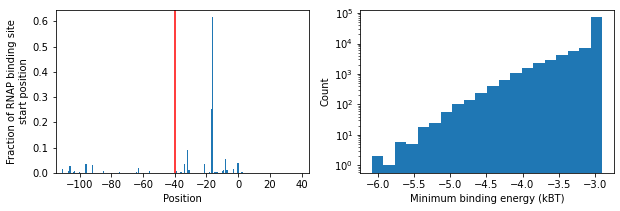

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
ax1, ax2 = axes[0], axes[1]

x = np.arange(-115, 45)
start_sites[74] = 0
ax1.bar(x, start_sites / 10000)
ax1.axvline(75-115, color='red')
ax1.set_xlim(-115, 45)
ax1.set_xlabel('Position')
ax1.set_ylabel('Fraction of RNAP binding site\nstart position')

ax2.hist(min_energies, bins=20)
ax2.set_yscale('log')
ax2.set_xlabel('Minimum binding energy (kBT)')
ax2.set_ylabel('Count')

plt.show()

Next, let's slide the energy matrix across each mutant sequence and check whether the region of minimum energy correspond to the expected binding site.

In [9]:
O1_start, O1_end = tregseq.seq_utils.find_binding_site(lacO1, O1)
print('The repressor binding site is from {} to {}'.format(O1_start, O1_end))

The repressor binding site is from 115 to 136


In [10]:
lenWT = len(O1)

start_sites = np.zeros(160)
min_energies = []
for mut in lacO1_mutants:
    min_energy = -15.3
    start = 115
    for i in range(160 - lenWT):
        subseq = mut[i:(i+lenWT)].upper()
        assert len(subseq) == lenWT
        benergy = tregseq.simulate.get_d_energy(subseq, O1_emat, e_wt=-15.3)
        if benergy <= min_energy:
            start = i
            min_energy = benergy
    start_sites[start] += 1
    min_energies.append(min_energy)

In [11]:
start_sites[115]

100000.0

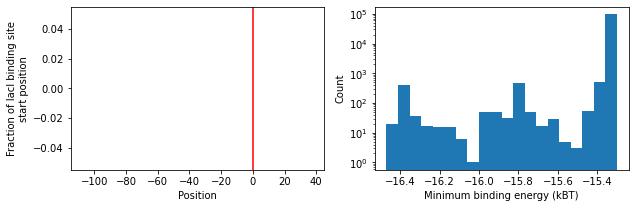

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
ax1, ax2 = axes[0], axes[1]

x = np.arange(-115, 45)
start_sites[115] = 0
ax1.bar(x, start_sites / 10000)
ax1.axvline(0, color='red')
ax1.set_xlim(-115, 45)
ax1.set_xlabel('Position')
ax1.set_ylabel('Fraction of lacI binding site\nstart position')

ax2.hist(min_energies, bins=20)
ax2.set_yscale('log')
ax2.set_xlabel('Minimum binding energy (kBT)')
ax2.set_ylabel('Count')

plt.show()